## 非線形振動子

FitzHugh-Nagumoモデルを例に取る．

$$
\dot{\mathbf{x}}=\mathbf{F}(\mathbf{x})
$$



In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot

In [2]:
@kwdef struct FHNParameter{FT}
    a::FT = 0.7
    b::FT = 0.8
    c::FT = 10.0
end

@kwdef mutable struct FHN{FT}
    param::FHNParameter = FHNParameter{FT}()
    N::UInt16
    v::Vector{FT} = fill(-1.0, N)
    u::Vector{FT} = zeros(N)
end

In [5]:
function update!(variable::FHN, param::FHNParameter, Ie::Vector, dt)
    @unpack N, v, u = variable
    @unpack a, b, c = param
    @inbounds for i = 1:N
        v[i] += dt * c * (-u[i] + v[i] - v[i]^3 / 3 + Ie[i])
        u[i] += dt * (v[i] - b*u[i] + a)
    end
end

update! (generic function with 1 method)

In [6]:
T = 50 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
Ie = repeat(0.35f0*ones(nt), 1, N)  # injection current

# 記録用
varr, uarr = zeros(Float32, nt, N), zeros(Float32, nt, N)

# modelの定義
neurons = FHN{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    varr[i, :], uarr[i, :] = neurons.v, neurons.u
end

  0.121324 seconds (249.93 k allocations: 12.893 MiB, 94.06% compilation time)


## 相空間とリミットサイクル

In [7]:
margin = 1.0
vmax, vmin = maximum(varr) + margin, minimum(varr) - margin
umax, umin = maximum(uarr) + margin, minimum(uarr) - margin
vrange, urange = vmin:0.1:vmax, umin:0.1:umax
U = [i for i in urange, j in 1:length(vrange)]
V = [j for i in 1:length(urange), j in vrange]

a, b, c, Ie = 0.7, 0.8, 10.0, 0.34
dV = c * (-U + V - V .^3 / 3 .+ Ie)
dU = V - b*U .+ a;

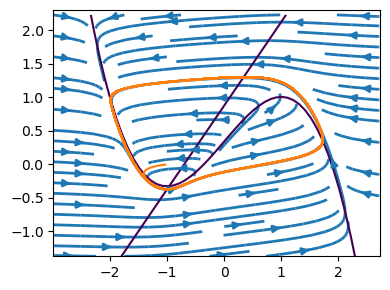

In [8]:
figure(figsize=(4,3))
streamplot(V, U, dV, dU, density=[0.8, 0.8], linewidth=2) 
contour(V, U, dU, levels=[0])
contour(V, U, dV, levels=[0])
plot(varr, uarr); xlim(vmin, vmax); ylim(umin, umax)
tight_layout()

## 位相の定義

In [ ]:
function FindStablePeriodicSolution(
    F, input_param, D::Int, Nθ::Int, initX=nothing, dt=1e-4, alg=Tsit5(),
    origin_val_idx::Int=1, origin_thr=nothing;
    TREL=200.0, RMAX=Int(5e6), NTRIAL=3, print_progress=true)

    """
    Find a stable periodic solution and compute period T and frequency ω.

    Args:
    - F(X, input_param) : Vector field function of the oscillator model; (list of functions)
    - I   : External force strength; (Scalar)
    - D   : Dimension of states; (Int)
    - Nθ  : The number of splitting phase for one period; (Int)
    - initX   : initial X states
    - origin_val_idx: index of variable which is criterion for zero phase (default:1) 1≦origin_val_idx≦D
    - origin_thr : threshold of zero phase (default:nothing->mean of X1)
    - dt : Time step for numerical integration
    - nimode : Numerical integration mode ("Euler", "RK4")
    - TREL : Initial relaxation time
    - TWAIT : Waiting time for measuring the oscillation period
    - RMAX : Buffer length

    Returns:
    - T : Period of stable periodic solutions (sec)
    - ω : Angular frequency of stable periodic solutions (Hz)
    - Xs(θ) : Stable periodic solutions ∈ R^(D x N_θ)
    """

    # Define the initial state of the state vector.
    if initX == nothing
        initX = rand(D)
    end

    """Determining the points that correspond to phase zero."""

    @assert (1 <= origin_val_idx <= D) "origin_val_idx must be in range [1, D]."

    function update!(dX, X, input_param, t)
        dX[:] = F(X, input_param...)
    end

    # Discard initial relaxation to the limit-cycle orbit
    if print_progress println("[1/4] Relaxation...") end
    integrator = get_ode_integrator(update!, initX, dt, input_param, alg)

    step!(integrator, TREL, true)

    # If origin_thr is not defined, the state after TREL (sec) from the initial state is set to phase zero.
    if origin_thr == nothing
        NTREL = Int(TREL/dt)
        Xrec = zeros(D, NTREL) # recording array
        for tt in 1:NTREL
            Xrec[:, tt] = integrator.u
            step!(integrator, dt, true)
        end

        origin_thr = median(Xrec[origin_val_idx, :])
    end

    if print_progress println("[2/4] Looking for the origin of the state X...") end
    for trial in 1:NTRIAL
        if trial > 1
            integrator = get_ode_integrator(update!, initX, dt, input_param, alg)
        end
        # Xarr = zeros(RMAX, D)
        for tt in 1:RMAX
            step!(integrator, dt, true)
            Xtm1 = integrator.uprev
            Xt = integrator.u
            #Xarr[tt, :] = Xt
            if tt > 1 && (Xtm1[origin_val_idx] < origin_thr) && (Xt[origin_val_idx] > origin_thr)
                # Linear interpolation: f(x) = f(x0) + (x - x0)/(x1 - x0) * (f(x1) - f(x0))
                global originX = Xtm1 + (origin_thr - Xtm1[origin_val_idx])/(Xt[origin_val_idx] - Xtm1[origin_val_idx]) * (Xt - Xtm1)
                @goto label #break
            elseif tt >= RMAX
                if trial >= NTRIAL
                    break
                end
                # @assert false "Insufficient buffer or wrong time step."
                println("Insufficient time step. Set dt=", dt, "->", dt*10)
                dt *= 10.0 # Multiply the time step by ten. Set the first time step small.)
                """
                plt.figure(figsize=(5, 4))
                plt.plot(Xarr[:, 1], Xarr[:, 2])
                plt.savefig("figure"*string(trial)*".png")
                """
            end
        end
        if trial >= NTRIAL
            @assert false "Insufficient buffer or wrong time step."
        end
    end

    @label label

    """Numerically integrate with setting the phase of state originX as zero
    and compute until the phase comes to zero (θ(t)=ω(t+t0)=2πk (k ∈ N)) again.
    Calculate the period T, the angular frequency ω = 2π/T．"""

    if print_progress println("[3/4] Measuring the oscillation period...") end

    T = 0 # period
    ω = 0 # angular frequency

    reinit!(integrator, originX)
    #  Measure the oscillation period. Here, X is originX.
    for tt in 1:RMAX
        step!(integrator, dt, true)
        Xtm1 = integrator.uprev
        Xt = integrator.u

        if tt > 1 && (Xtm1[origin_val_idx] < origin_thr) && (Xt[origin_val_idx] > origin_thr)
            T = tt*dt
            ω = 2*pi/T
            break
        elseif (tt >= RMAX)
            @assert false "Insufficient buffer or wrong time step."
        end
    end

    """Perform numerical integration for one period with time step size dt=T/Nθ
    and compute the solution as a stable periodic solution."""

    if print_progress println("[4/4] Computing the stable periodic solution...") end
    Xs = zeros(D, Nθ)
    dtθ = T / Nθ

    # update integrator
    integrator = get_ode_integrator(update!, initX, dtθ, input_param, alg)
    reinit!(integrator, originX)

    # Record X for one period
    for tt in 1:Int(Nθ)
        Xs[:, tt] = integrator.u
        step!(integrator, dtθ, true)
    end

    return T, ω, Xs
end

In [ ]:
@time T₀, ω₀, Xs = FindStablePeriodicSolution(F, input_param, D, Nθ, initX, dt, Tsit5())
println("T₀=", T₀, " (sec) , ω₀=", ω₀, " (Hz)")

In [ ]:
figure(figsize=(3, 3))
scatter(Xs[1, 1], Xs[2, 1], color="black", label="origin") 
plot(Xs[1, :], Xs[2, :])
grid(); legend(); xlabel(L"$x$"); ylabel(L"$y$")
tight_layout()

## 位相応答関数